In [1]:
%matplotlib widget

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.linalg import expm
from scipy.signal import savgol_filter

import os
import pickle

In [74]:
filepath = "~/user-in-the-box/output/log_100episodes_100Hz.pickle"  #"~/user-in-the-box/output/log.pickle"

with open(os.path.expanduser(filepath), "rb") as f:
    data = pickle.load(f)


In [75]:
def project_trajectory(trajectory, init_val=None, final_val=None):
    if init_val is None:
        init_val = trajectory[0]
    if final_val is None:
        final_val = trajectory[-1]
    init_val = np.array(init_val)
    final_val = np.array(final_val)
    proj_vector = final_val - init_val
    proj_vector /= np.linalg.norm(proj_vector)**2  #normalize vector to project on
    
    projected_trajectory = np.array([np.dot(state_vec - init_val, proj_vector) for state_vec in trajectory])
    return projected_trajectory

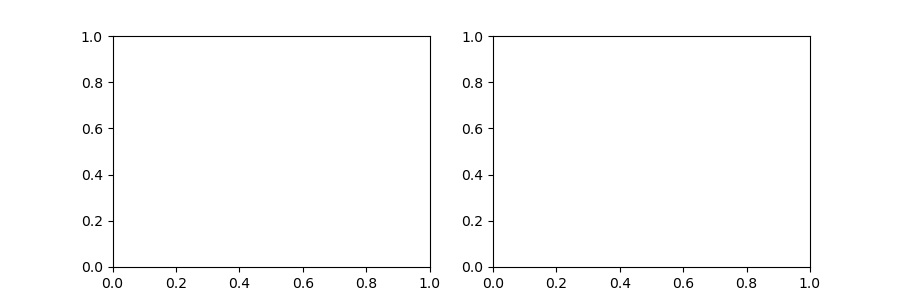

In [76]:
if "endeffector_fig" in locals():
    plt.close(endeffector_fig)
# endeffector_fig = plt.figure()
# endeffector_ax = endeffector_fig.gca()
endeffector_fig, endeffector_ax = plt.subplots(1, 2, figsize=[9, 3])

In [167]:
for axis in endeffector_ax:
    axis.clear()
endeffector_fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.26, hspace=0.2)

####
EPISODE_ID = "008".zfill(3 + ("100episodes" not in filepath))
NORMALIZE_TIME = True
MINJERK_USER_CONSTRAINTS = True
####

time_per_step = np.diff(data[f"episode_{EPISODE_ID}"]["timestep"]).mean()  #0.01
indices = np.append(np.insert(np.where(data[f"episode_{EPISODE_ID}"]["target_hit"])[0], 0, 0), len(data[f"episode_{EPISODE_ID}"]["target_hit"]))

position_series = data[f"episode_{EPISODE_ID}"]["fingertip_xpos"]
velocity_series = data[f"episode_{EPISODE_ID}"]["fingertip_xvelp"]

# recover end-effector position time series [only for corrupted pickle file]
if filepath.endswith("log.pickle"):
    position_series = (np.cumsum(velocity_series, axis=0) * time_per_step)
    position_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = time_per_step)).values
    position_series += data[f"episode_{EPISODE_ID}"]["target_position"][indices[1] - 1] - position_series[indices[1]] #ensure that target is reached at target hit/switch time

#velocity_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=1, delta = time_per_step)).values
acceleration_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=2, delta = time_per_step)).values

solid_line = Line2D([0], [0], color='black', linestyle='-', label='Simulation Data')
dashed_line = Line2D([0], [0], color='black', linestyle='--', label='MinJerk Trajectory')
endeffector_ax[0].legend(handles=[solid_line, dashed_line])

for last_idx, current_idx, next_idx in list(zip([-1] + indices, indices, indices[1:]))[2:4]:
    time_series_shifted = np.array(data[f"episode_{EPISODE_ID}"]["timestep"][current_idx: next_idx]) - data[f"episode_{EPISODE_ID}"]["timestep"][current_idx]
    if NORMALIZE_TIME:
        time_series_shifted = (time_series_shifted - time_series_shifted[0])/(time_series_shifted[-1] - time_series_shifted[0])
    
    ## ANALYZE POSITION
    # apply Savitzky Golay Filter
    projected_trajectory = project_trajectory(position_series[current_idx: next_idx], init_val=data[f"episode_{EPISODE_ID}"]["target_position"][last_idx] if last_idx >= 0 else position_series[0], final_val=data[f"episode_{EPISODE_ID}"]["target_position"][current_idx])
    endeffector_ax[0].plot(time_series_shifted, projected_trajectory)
    endeffector_ax[0].set_title("Projected Position Time Series")
    endeffector_ax[0].set_xlabel("Time (s)")
    endeffector_ax[0].set_ylabel("Position (m) [normalized]")

    ## ANALYZE VELOCITY
    # apply Savitzky Golay Filter
    projected_trajectory = project_trajectory(velocity_series[current_idx: next_idx], init_val=data[f"episode_{EPISODE_ID}"]["target_position"][last_idx] if last_idx >= 0 else position_series[0], final_val=data[f"episode_{EPISODE_ID}"]["target_position"][current_idx])
    latest_plot, = endeffector_ax[1].plot(time_series_shifted, projected_trajectory)
    endeffector_ax[1].set_title("Projected Velocity Time Series")
    endeffector_ax[1].set_xlabel("Time (s)")
    endeffector_ax[1].set_ylabel("Velocity (m/s) [normalized]")
    
    ## REFERENCE TRAJECTORY: MinJerk
    if MINJERK_USER_CONSTRAINTS:
        T = [np.concatenate((position_series[current_idx], position_series[next_idx - 1]))]
    else:
        T = [np.squeeze([data[f"episode_{EPISODE_ID}"]["target_position"][last_idx] if last_idx >= 0 else position_series[0], data[f"episode_{EPISODE_ID}"]["target_position"][current_idx]]).reshape(-1,)]
    x0 = np.concatenate((np.squeeze([position_series[current_idx], velocity_series[current_idx], acceleration_series[current_idx]]).reshape(-1,), T[0]))
    dim = 3
    x_minjerk, u_minjerk = minimumjerk_deterministic(next_idx - current_idx - 1, x0=x0, T=T, P=2, dim=dim, dt=time_per_step, initialuservalues=None)
    x_minjerk_pos = x_minjerk[:, :dim]
    x_minjerk_vel = x_minjerk[:, dim:2*dim]
    x_minjerk_acc = x_minjerk[:, 2*dim:3*dim]
    init_val = data[f"episode_{EPISODE_ID}"]["target_position"][last_idx] if last_idx >= 0 else position_series[0]
    final_val = data[f"episode_{EPISODE_ID}"]["target_position"][current_idx]
    projected_minjerk_trajectory_pos = project_trajectory(x_minjerk_pos, init_val=init_val, final_val=final_val)
    endeffector_ax[0].plot(time_series_shifted, projected_minjerk_trajectory_pos, linewidth=1.5, color=latest_plot.get_color(), linestyle="--")
    projected_minjerk_trajectory_vel = project_trajectory(x_minjerk_vel, init_val=init_val, final_val=final_val)
    endeffector_ax[1].plot(time_series_shifted, projected_minjerk_trajectory_vel, linewidth=1.5, color=latest_plot.get_color(), linestyle="--")

In [13]:

# position_series = (np.cumsum(velocity_series, axis=0) * time_per_step)
# position_series = pd.DataFrame(position_series).apply(lambda x: savgol_filter(x, 15, 3, deriv=0, delta = time_per_step)).values
# position_series += data[f"episode_{EPISODE_ID}"]["target_position"][indices[1]-1] - position_series[indices[1]-1] #ensure that target is reached at target hit/switch time

position_series[10], data[f"episode_{EPISODE_ID}"]["target_position"][10]

(array([0.47877647, 0.07193766, 0.67080054]),
 array([0.5       , 0.077499  , 0.69959767]))

In [103]:
# Compute Minjerk trajectory as reference trajectory
def minimumjerk_deterministic(N, T, initialuservalues, dim, P, dt, x0, passage_times=None):
    if x0 is None:
        x0 = np.hstack((np.mean(np.squeeze(initialuservalues), axis=0), T[0]))

    if passage_times is None:
        passage_times = np.linspace(0, N, P).astype(
            int)  # WARNING: here: equally distributed target passage times!
    # else:
    #     passage_times = np.insert(passage_times, 0, 0)  #assume that argument "passage_times" had P - 1 values, as first "target switch" (i.e., from initial position to first real target) is fixed

    assert len(passage_times) == P

    n = dim * (3 + P)  # dimension of state vector (incorporating position, velocity, acceleration and "via-points" T)

    assert P == 2
    N_minjerk = np.ceil(passage_times[1]).astype(int)

#     ### VARIANT 1:
#     ## (Online) Control Algorithm
    
#     A = [None] * (N_minjerk)
#     B = [None] * (N_minjerk)
    
#     x = np.zeros((N + 1, n))
#     u = np.zeros((N, dim))

#     x[0] = x0
#     for i in range(0, N_minjerk):
#         u[i] = T[0][1*dim:]

#         ### COMPUTE time-dependent system matrices (with time relexation due to usage of passage_times[1] instead of int(passage_times[1]); for stochastic wrapper, see minjerk_get_all_timedependent_system_matrices()):
#         movement_time = (passage_times[1] - i) * dt
#         A_continuous = np.vstack(
#             (np.hstack((np.zeros(shape=(dim, dim)), np.eye(dim), np.zeros(shape=(dim, (P + 1) * dim)))),
#              np.hstack((np.zeros(shape=(dim, 2 * dim)), np.eye(dim), np.zeros(shape=(dim, P * dim)))),
#              np.hstack(((-60 / (movement_time ** 3)) * np.eye(dim), (-36 / (movement_time ** 2)) * np.eye(dim),
#                         (-9 / movement_time) * np.eye(dim), np.zeros(shape=(dim, P * dim)))),
#              np.zeros(shape=(P * dim, (P + 3) * dim))))
#         B_continuous = np.vstack((np.zeros(shape=(2 * dim, dim)),
#                                   (60 / (movement_time ** 3)) * np.eye(dim), np.zeros(shape=(P * dim, dim))))
#         # using explicit solution formula:
#         A[i] = expm(A_continuous * dt)
#         B[i] = np.linalg.pinv(A_continuous).dot(A[i] - np.eye((3 + P) * dim)).dot(B_continuous)
#         # B[i] = np.vstack((np.linalg.inv(A_continuous[:3*dim, :3*dim]).dot(A[i][:3*dim, :3*dim] - np.eye(3 * dim)).dot(B_continuous[:3*dim]),
#         #                     np.zeros(shape=(P * dim, dim))))
#         ############################################

#         x[i + 1] = A[i].dot(x[i]) + B[i].dot(u[i])

#     for i in range(N_minjerk, N):  # extend trajectory with constant last value
#         u[i] = T[0][1*dim:]
#         x[i + 1] = x[i] * np.repeat(np.array([1, 0, 0, 1, 1]), dim)

    ### VARIANT 2:
    # Explicit Solution Formula (current implementation only yields position time series!)
    t_f = passage_times[1] * dt
    #compute MinJerk trajectory per dimension
    
    #SHORT CODE:
    coeff_vec = np.array([[x0[0 + i], t_f * x0[1*dim + i], 0.5 * (t_f ** 2) * x0[2*dim + i],
                       -10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i],
                       15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i],
                       -6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i]] for i in range(dim)] + 
                    [[x0[1*dim + i], t_f * x0[2*dim + i],
                       (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i]),
                       (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i]),
                       (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i]), 0] for i in range(dim)] +
                    [[x0[2*dim + i],
                   (2 / t_f) * (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i]),
                   (3 / t_f) * (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i]),
                   (4 / t_f) * (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i]), 0, 0] for i in range(dim)])
    x = np.squeeze([coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(6)]) for j in range(N_minjerk + 1)])
    #LONG CODE:
    # x = []
    # for i in range(dim):  #position
    #     coeff_vec = np.array([x0[0 + i], t_f * x0[1*dim + i], 0.5 * (t_f ** 2) * x0[2*dim + i],
    #                        -10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i],
    #                        15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i],
    #                        -6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i]])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(6)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # for i in range(dim):  #velocity
    #     coeff_vec = np.array([x0[1*dim + i], t_f * x0[2*dim + i],
    #                        (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i]),
    #                        (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i]),
    #                        (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i])])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(5)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # for i in range(dim):  #acceleration
    #     coeff_vec = np.array([x0[2*dim + i],
    #                        (2 / t_f) * (3 / t_f) * (-10 * x0[0 + i] - 6 * t_f * x0[1*dim + i] - 1.5 * (t_f ** 2) * x0[2*dim + i] + 10 * T[0][1*dim + i]),
    #                        (3 / t_f) * (4 / t_f) * (15 * x0[0 + i] + 8 * t_f * x0[1*dim + i] + 1.5 * (t_f ** 2) * x0[2*dim + i] - 15 * T[0][1*dim + i]),
    #                        (4 / t_f) * (5 / t_f) * (-6 * x0[0 + i] - 3 * t_f * x0[1*dim + i] - 0.5 * (t_f ** 2) * x0[2*dim + i] + 6 * T[0][1*dim + i])])
    #     x_current_dimension = [coeff_vec @ np.array([(j / passage_times[1]) ** ii for ii in range(4)]) for j in range(N_minjerk + 1)]
    #     x.append(x_current_dimension)
    # x = np.array(x).T
    
    if N > N_minjerk:
        x = np.concatenate((x, [x[-1]] * (N - N_minjerk)))
    u = None  #[T[0][1*dim:]] * (N_minjerk + 1)

    return x, u



In [67]:
x_minjerk, u_minjerk = minimumjerk_deterministic(10, x0=x0, T=T, P=2, dim=3, dt=time_per_step, initialuservalues=None)
x_minjerk, u_minjerk

(array([[ 5.26353056e-01, -4.67794226e-02,  8.26291181e-01,
         -6.54131706e-02, -3.31623495e-02,  2.81398382e-01,
         -6.89340602e-02,  2.65549006e-01, -9.07672374e-01],
        [ 5.19677003e-01, -4.89344349e-02,  8.46896716e-01,
         -6.62254384e-02, -1.15087644e-02,  1.06004568e-01,
          4.41581612e-02,  1.71258117e-01, -2.39477890e+00],
        [ 5.13403509e-01, -4.93591573e-02,  8.44465546e-01,
         -5.81424704e-02,  1.79762085e-03, -1.61114033e-01,
          1.10422420e-01,  9.82176366e-02, -2.78858450e+00],
        [ 5.08202474e-01, -4.87859315e-02,  8.14827533e-01,
         -4.54115336e-02,  8.76563528e-03, -4.24552248e-01,
          1.38569302e-01,  4.41033275e-02, -2.36758756e+00],
        [ 5.04362626e-01, -4.77578375e-02,  7.61960565e-01,
         -3.14088364e-02,  1.11716841e-02, -6.16754739e-01,
          1.37309391e-01,  6.59095204e-03, -1.41028643e+00],
        [ 5.01878626e-01, -4.66519359e-02,  6.95205571e-01,
         -1.86395290e-02,  1.055974